# Korean Drama Recommender

I love watching Korean Dramas so I wanted to see if I could make my own recommender. I took the categories from the dataset I thought were most interesting and did some EDA on them and then used ML to create the recommender.c

## Preliminary Analysis

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.filterwarnings("ignore")
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to /home/labsuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/labsuser/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/labsuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/labsuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("kdrama.csv")

In [3]:
df.head()

,Name,Aired Date,Year of release,Original Network,Aired On,Number of Episodes,Duration,Content Rating,Rating,Synopsis,Genre,Tags,Director,Screenwriter,Cast,Production companies,Rank
0,Move to Heaven,"May 14, 2021",2021,Netflix,Friday,10,52 min.,18+ Restricted (violence & profanity),9.2,Geu Roo is a young autistic man. He works for ...,"Life, Drama, Family","Autism, Uncle-Nephew Relationship, Death, Sava...",Kim Sung Ho,Yoon Ji Ryun,"Lee Je Hoon, Tang Jun Sang, Hong Seung Hee, Ju...","Page One Film, Number Three Pictures",#1
1,Flower of Evil,"Jul 29, 2020 - Sep 23, 2020",2020,tvN,"Wednesday, Thursday",16,1 hr. 10 min.,15+ - Teens 15 or older,9.1,Although Baek Hee Sung is hiding a dark secret...,"Thriller, Romance, Crime, Melodrama","Married Couple, Deception, Suspense, Family Se...","Kim Chul Gyu, Yoon Jong Ho",Yoo Jung Hee,"Lee Joon Gi, Moon Chae Won, Jang Hee Jin, Seo ...",Monster Union,#2
2,Hospital Playlist,"Mar 12, 2020 - May 28, 2020",2020,"Netflix, tvN",Thursday,12,1 hr. 30 min.,15+ - Teens 15 or older,9.1,The stories of people going through their days...,"Friendship, Romance, Life, Medical","Strong Friendship, Multiple Mains, Best Friend...",Shin Won Ho,Lee Woo Jung,"Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...","Egg Is Coming, CJ ENM",#3
3,Hospital Playlist 2,"Jun 17, 2021 - Sep 16, 2021",2021,"Netflix, tvN",Thursday,12,1 hr. 40 min.,15+ - Teens 15 or older,9.1,Everyday is extraordinary for five doctors and...,"Friendship, Romance, Life, Medical","Workplace, Strong Friendship, Best Friends, Mu...",Shin Won Ho,Lee Woo Jung,"Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...","Egg Is Coming, CJ ENM",#4
4,My Mister,"Mar 21, 2018 - May 17, 2018",2018,tvN,"Wednesday, Thursday",16,1 hr. 17 min.,15+ - Teens 15 or older,9.1,Park Dong Hoon is a middle-aged engineer who i...,"Psychological, Life, Drama, Family","Age Gap, Nice Male Lead, Strong Female Lead, H...","Kim Won Suk, Kim Sang Woo",Park Hae Young,"Lee Sun Kyun, IU, Park Ho San, Song Sae Byuk, ...",Chorokbaem Media,#5


In [4]:
#cleaning data
df['Rank']=df['Rank'].str.replace('#','').astype(int)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  250 non-null    object 
 1   Aired Date            250 non-null    object 
 2   Year of release       250 non-null    int64  
 3   Original Network      250 non-null    object 
 4   Aired On              250 non-null    object 
 5   Number of Episodes    250 non-null    int64  
 6   Duration              250 non-null    object 
 7   Content Rating        245 non-null    object 
 8   Rating                250 non-null    float64
 9   Synopsis              250 non-null    object 
 10  Genre                 250 non-null    object 
 11  Tags                  250 non-null    object 
 12  Director              249 non-null    object 
 13  Screenwriter          249 non-null    object 
 14  Cast                  250 non-null    object 
 15  Production companies  2

In [6]:
df.isnull().sum().sort_values(ascending=False)

Content Rating          5
Production companies    2
Screenwriter            1
Director                1
Rank                    0
Number of Episodes      0
Aired Date              0
Year of release         0
Original Network        0
Aired On                0
Rating                  0
Duration                0
Synopsis                0
Genre                   0
Tags                    0
Cast                    0
Name                    0
dtype: int64

In [7]:
#drop missing
df.dropna(inplace=True)

In [8]:
#anything other than lower case az, upper AZ, numbers, and space get replaced with empty string.
def clean_name(name):
    name = re.sub("[^a-zA-Z0-9 ]", "", name)
    return name

In [9]:
#cleaning name
df["clean_name"] = df["Name"].apply(clean_name)

In [10]:
#extract hours and minutes from the duration column
hours = df['Duration'].str.extract(r'(\d+)\s*hr').astype(float)
minutes = df['Duration'].str.extract(r'(\d+)\s*min').astype(float)

#convert hours and minutes to minutes
hours = hours.fillna(0) * 60
minutes = minutes.fillna(0)

#calculate the total duration in minutes
total_duration = hours + minutes

#duration column should only be minutes now
df['Duration'] = total_duration

In [11]:
df.head(10)

,Name,Aired Date,Year of release,Original Network,Aired On,Number of Episodes,Duration,Content Rating,Rating,Synopsis,Genre,Tags,Director,Screenwriter,Cast,Production companies,Rank,clean_name
0,Move to Heaven,"May 14, 2021",2021,Netflix,Friday,10,52.0,18+ Restricted (violence & profanity),9.2,Geu Roo is a young autistic man. He works for ...,"Life, Drama, Family","Autism, Uncle-Nephew Relationship, Death, Sava...",Kim Sung Ho,Yoon Ji Ryun,"Lee Je Hoon, Tang Jun Sang, Hong Seung Hee, Ju...","Page One Film, Number Three Pictures",1,Move to Heaven
1,Flower of Evil,"Jul 29, 2020 - Sep 23, 2020",2020,tvN,"Wednesday, Thursday",16,70.0,15+ - Teens 15 or older,9.1,Although Baek Hee Sung is hiding a dark secret...,"Thriller, Romance, Crime, Melodrama","Married Couple, Deception, Suspense, Family Se...","Kim Chul Gyu, Yoon Jong Ho",Yoo Jung Hee,"Lee Joon Gi, Moon Chae Won, Jang Hee Jin, Seo ...",Monster Union,2,Flower of Evil
2,Hospital Playlist,"Mar 12, 2020 - May 28, 2020",2020,"Netflix, tvN",Thursday,12,90.0,15+ - Teens 15 or older,9.1,The stories of people going through their days...,"Friendship, Romance, Life, Medical","Strong Friendship, Multiple Mains, Best Friend...",Shin Won Ho,Lee Woo Jung,"Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...","Egg Is Coming, CJ ENM",3,Hospital Playlist
3,Hospital Playlist 2,"Jun 17, 2021 - Sep 16, 2021",2021,"Netflix, tvN",Thursday,12,100.0,15+ - Teens 15 or older,9.1,Everyday is extraordinary for five doctors and...,"Friendship, Romance, Life, Medical","Workplace, Strong Friendship, Best Friends, Mu...",Shin Won Ho,Lee Woo Jung,"Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...","Egg Is Coming, CJ ENM",4,Hospital Playlist 2
4,My Mister,"Mar 21, 2018 - May 17, 2018",2018,tvN,"Wednesday, Thursday",16,77.0,15+ - Teens 15 or older,9.1,Park Dong Hoon is a middle-aged engineer who i...,"Psychological, Life, Drama, Family","Age Gap, Nice Male Lead, Strong Female Lead, H...","Kim Won Suk, Kim Sang Woo",Park Hae Young,"Lee Sun Kyun, IU, Park Ho San, Song Sae Byuk, ...",Chorokbaem Media,5,My Mister
5,Reply 1988,"Nov 6, 2015 - Jan 16, 2016",2015,tvN,"Friday, Saturday",20,100.0,15+ - Teens 15 or older,9.1,"Five childhood friends, who all live in the sa...","Comedy, Romance, Youth, Family","Neighbors, Slice Of Life, Childhood Friends, M...","Shin Won Ho, Yoo Hak Chan",Lee Woo Jung,"Lee Hye Ri, Go Kyung Pyo, Ryu Joon Yeol, Park ...",CJ ENM,6,Reply 1988
6,Weak Hero Class 1,"Nov 18, 2022",2022,Wavve,Friday,8,40.0,18+ Restricted (violence & profanity),9.1,Yeon Shi Eun is a model student who ranks at t...,"Action, Youth, Drama\r","Bromance, Smart Male Lead, Violence, School Bu...",You Su Min,Jun Hee Han,"Park Ji Hoon, Choi Hyun Wook, Hong Kyung, Kim ...",PlayList Global,7,Weak Hero Class 1
7,Prison Playbook,"Nov 22, 2017 - Jan 18, 2018",2017,"Netflix, tvN","Wednesday, Thursday",16,92.0,15+ - Teens 15 or older,9.1,"Kim Je Hyuk, a famous baseball player, is arre...","Comedy, Crime, Life, Drama","Prison, Bromance, Wrongfully Accused, Life Les...",Shin Won Ho,"Jung Bo Hoon, Lee Woo Jung","Park Hae Soo, Jung Kyung Ho, Krystal Jung, Im ...",tvN,8,Prison Playbook
8,Alchemy of Souls,"Jun 18, 2022 - Aug 28, 2022",2022,"Netflix, tvN","Saturday, Sunday",20,80.0,15+ - Teens 15 or older,9.0,Set in a fictional country called Daeho that d...,"Action, Historical, Romance, Fantasy","Magical Power, Supernatural, Transmigration, S...",Park Joon Hwa,"Hong Jung Eun, Hong Mi Ran","Lee Jae Wook, Jung So Min, Hwang Hyun Min, Shi...","Studio Dragon, High Quality",9,Alchemy of Souls
9,Extraordinary Attorney Woo,"Jun 29, 2022 - Aug 18, 2022",2022,"ENA, Netflix","Wednesday, Thursday",16,77.0,15+ - Teens 15 or older,9.0,"Diagnosed with autism spectrum disorder, 27-ye...","Law, Romance, Life, Drama","Autistic Female Lead, Autism, Attorney Female...",Yoo In Shik,Moon Ji Won,"Park Eun Bin, Kang Tae Oh, Kang Ki Young, Jeon...","AStory, KT Studio Genie, Nangman Crew",10,Extraordinary Attorney Woo


In [12]:
#extract numerical age from content rating column
df['Age Rating'] = df['Content Rating'].str.extract(r'(\d+)').astype(float)

In [13]:
#new column of age rating only has number
df.head()

,Name,Aired Date,Year of release,Original Network,Aired On,Number of Episodes,Duration,Content Rating,Rating,Synopsis,Genre,Tags,Director,Screenwriter,Cast,Production companies,Rank,clean_name,Age Rating
0,Move to Heaven,"May 14, 2021",2021,Netflix,Friday,10,52.0,18+ Restricted (violence & profanity),9.2,Geu Roo is a young autistic man. He works for ...,"Life, Drama, Family","Autism, Uncle-Nephew Relationship, Death, Sava...",Kim Sung Ho,Yoon Ji Ryun,"Lee Je Hoon, Tang Jun Sang, Hong Seung Hee, Ju...","Page One Film, Number Three Pictures",1,Move to Heaven,18.0
1,Flower of Evil,"Jul 29, 2020 - Sep 23, 2020",2020,tvN,"Wednesday, Thursday",16,70.0,15+ - Teens 15 or older,9.1,Although Baek Hee Sung is hiding a dark secret...,"Thriller, Romance, Crime, Melodrama","Married Couple, Deception, Suspense, Family Se...","Kim Chul Gyu, Yoon Jong Ho",Yoo Jung Hee,"Lee Joon Gi, Moon Chae Won, Jang Hee Jin, Seo ...",Monster Union,2,Flower of Evil,15.0
2,Hospital Playlist,"Mar 12, 2020 - May 28, 2020",2020,"Netflix, tvN",Thursday,12,90.0,15+ - Teens 15 or older,9.1,The stories of people going through their days...,"Friendship, Romance, Life, Medical","Strong Friendship, Multiple Mains, Best Friend...",Shin Won Ho,Lee Woo Jung,"Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...","Egg Is Coming, CJ ENM",3,Hospital Playlist,15.0
3,Hospital Playlist 2,"Jun 17, 2021 - Sep 16, 2021",2021,"Netflix, tvN",Thursday,12,100.0,15+ - Teens 15 or older,9.1,Everyday is extraordinary for five doctors and...,"Friendship, Romance, Life, Medical","Workplace, Strong Friendship, Best Friends, Mu...",Shin Won Ho,Lee Woo Jung,"Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...","Egg Is Coming, CJ ENM",4,Hospital Playlist 2,15.0
4,My Mister,"Mar 21, 2018 - May 17, 2018",2018,tvN,"Wednesday, Thursday",16,77.0,15+ - Teens 15 or older,9.1,Park Dong Hoon is a middle-aged engineer who i...,"Psychological, Life, Drama, Family","Age Gap, Nice Male Lead, Strong Female Lead, H...","Kim Won Suk, Kim Sang Woo",Park Hae Young,"Lee Sun Kyun, IU, Park Ho San, Song Sae Byuk, ...",Chorokbaem Media,5,My Mister,15.0


In [14]:
#creating New DataFrame with columns i think are most important
ndf = df[['Name', 'Year of release', 'Number of Episodes', 'Duration', 'Age Rating', 'Rating', 'Synopsis', 'Genre', 'Tags', 'Cast', 'Rank']] 

In [15]:
ndf.head()

,Name,Year of release,Number of Episodes,Duration,Age Rating,Rating,Synopsis,Genre,Tags,Cast,Rank
0,Move to Heaven,2021,10,52.0,18.0,9.2,Geu Roo is a young autistic man. He works for ...,"Life, Drama, Family","Autism, Uncle-Nephew Relationship, Death, Sava...","Lee Je Hoon, Tang Jun Sang, Hong Seung Hee, Ju...",1
1,Flower of Evil,2020,16,70.0,15.0,9.1,Although Baek Hee Sung is hiding a dark secret...,"Thriller, Romance, Crime, Melodrama","Married Couple, Deception, Suspense, Family Se...","Lee Joon Gi, Moon Chae Won, Jang Hee Jin, Seo ...",2
2,Hospital Playlist,2020,12,90.0,15.0,9.1,The stories of people going through their days...,"Friendship, Romance, Life, Medical","Strong Friendship, Multiple Mains, Best Friend...","Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...",3
3,Hospital Playlist 2,2021,12,100.0,15.0,9.1,Everyday is extraordinary for five doctors and...,"Friendship, Romance, Life, Medical","Workplace, Strong Friendship, Best Friends, Mu...","Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...",4
4,My Mister,2018,16,77.0,15.0,9.1,Park Dong Hoon is a middle-aged engineer who i...,"Psychological, Life, Drama, Family","Age Gap, Nice Male Lead, Strong Female Lead, H...","Lee Sun Kyun, IU, Park Ho San, Song Sae Byuk, ...",5


## Visualization

<AxesSubplot:>

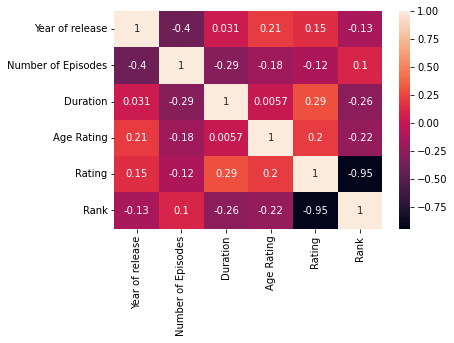

In [16]:
#kdramas seem to have less episodes as the years go on
sns.heatmap(ndf.corr(),annot=True)

### Release Year

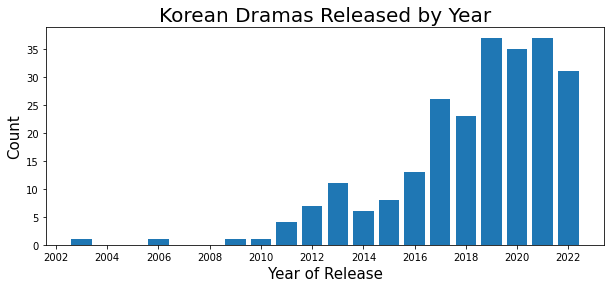

In [17]:
#group the data by 'Year of release' and calculate the count
grouped_year = ndf.groupby('Year of release').size().reset_index().rename(columns={0: 'Count'})

#create the bar graph
plt.figure(figsize=(10, 4))
plt.bar(data=grouped_year, x='Year of release', height='Count')

#plot title and axis labels
plt.title('Korean Dramas Released by Year', fontsize=20)
plt.xlabel('Year of Release', fontsize=15)
plt.ylabel('Count', fontsize=15)

#x-axis tick values
years = np.arange(2002, 2023, 2)
plt.xticks(years)

plt.show()

### Number of episodes

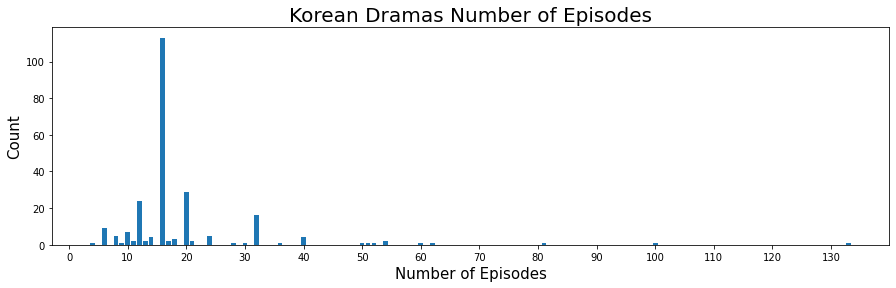

In [18]:
#group data by 'Number of Episodes' and calculate count
grouped_ep = ndf.groupby('Number of Episodes').size().reset_index().rename(columns={0: 'Count'})

#bar graph
plt.figure(figsize=(15, 4))
plt.bar(data=grouped_ep, x='Number of Episodes', height='Count')

#plot title and axis labels
plt.title('Korean Dramas Number of Episodes', fontsize=20)
plt.xlabel('Number of Episodes', fontsize=15)
plt.ylabel('Count', fontsize=15)

#x-axis tick values
ep = np.arange(0, ndf['Number of Episodes'].max(), 10)
plt.xticks(ep)

plt.show()

### Duration

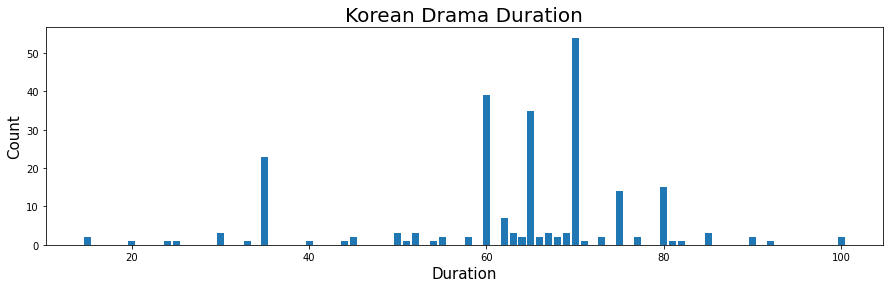

In [19]:
#grouped data by 'Duration' and calculate the count
grouped_dur = ndf.groupby('Duration').size().reset_index().rename(columns={0: 'Count'})

#bar graph
plt.figure(figsize=(15, 4))
plt.bar(data=grouped_dur, x='Duration', height='Count')

#plot title and axis labels
plt.title('Korean Drama Duration', fontsize=20)
plt.xlabel('Duration', fontsize=15)
plt.ylabel('Count', fontsize=15)

plt.show()

### Content Rating

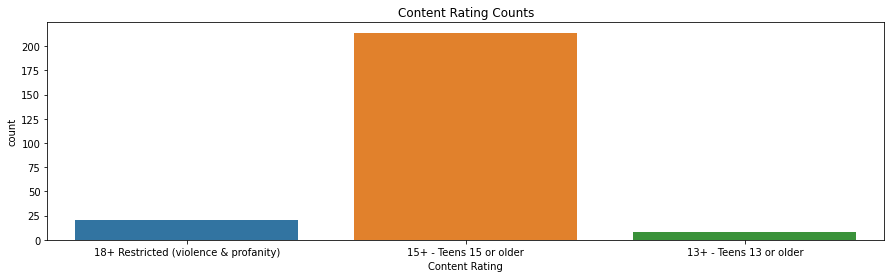

In [20]:
#count plot
plt.figure(figsize=(15, 4))
sns.countplot(x='Content Rating', data=df)

#plot title
plt.title('Content Rating Counts')

plt.show()

### Genres

In [21]:
#split genres and count per genre
genre_list = []
for genres in ndf['Genre'].str.split(", "):
    genre_list.extend(genres)

genre_counts = dict(Counter(genre_list))

#make df with all genres and their respective counts
genre_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['Count'])
genre_df.sort_values(by='Count', ascending=False, inplace=True)
genre_df.head()

,Count
Romance,89
Thriller,71
Drama,69
Comedy,62
Mystery,61


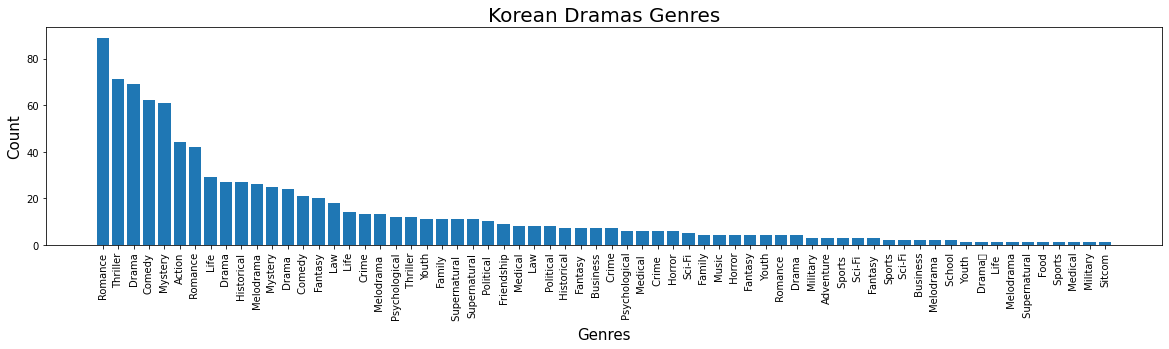

In [22]:
#bar graph
plt.figure(figsize=(20, 4))
plt.bar(data=genre_df, x=genre_df.index, height='Count')

#plot title and axis labels
plt.title('Korean Dramas Genres', fontsize=20)
plt.xlabel('Genres', fontsize=15)
plt.ylabel('Count', fontsize=15)

#rotate x-axis labels
plt.xticks(rotation=90)

plt.show()

### Tags

In [23]:
#split tags and count per tag like the genres
tag_list = []
for tag in ndf['Tags'].str.split(", "):
    tag_list.extend(tag)

tag_counts = dict(Counter(tag_list))

# Create a DataFrame with all genres and their counts
tag_df = pd.DataFrame.from_dict(tag_counts, orient='index', columns=['Count'])
tag_df.sort_values(by='Count', ascending=False, inplace=True)
tag_df.head()

,Count
Strong Female Lead,95
Smart Female Lead,47
Nice Male Lead,45
Smart Male Lead,45
Murder,41


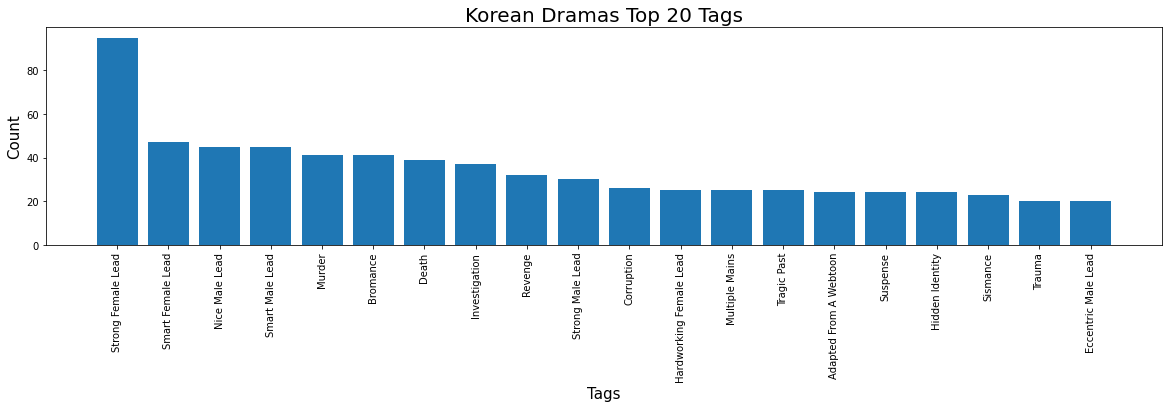

In [24]:
#bar graph
plt.figure(figsize=(20, 4))
plt.bar(data=tag_df.head(20), x = tag_df.iloc[:20].index, height='Count')

#plot title and axis labels
plt.title('Korean Dramas Top 20 Tags', fontsize=20)
plt.xlabel('Tags', fontsize=15)
plt.ylabel('Count', fontsize=15)

#rotate x-axis labels
plt.xticks(rotation=90)

plt.show()

In [25]:
#lowest and highest rating scores
ndf['Rating'].min(), ndf['Rating'].max()

(8.3, 9.2)

### Cast

In [26]:
#splitting cast members of each drama
cast_list = list()

for casts in ndf['Cast'].to_list():
    casts = casts.split(", ")
    for a in casts:
        cast_list.append(a)
        
#putting each individual cast member and their appearance in a df
cast_df = pd.DataFrame.from_dict(Counter(cast_list),orient = 'index').rename(columns = {0:'Appearance'})
cast_df.sort_values(by='Appearance',ascending = False,inplace = True)
cast_df.head()

,Appearance
Lee Joon Hyuk,8
Shin Hye Sun,7
Ahn Bo Hyun,7
Lee Jong Suk,6
Uhm Ki Joon,6


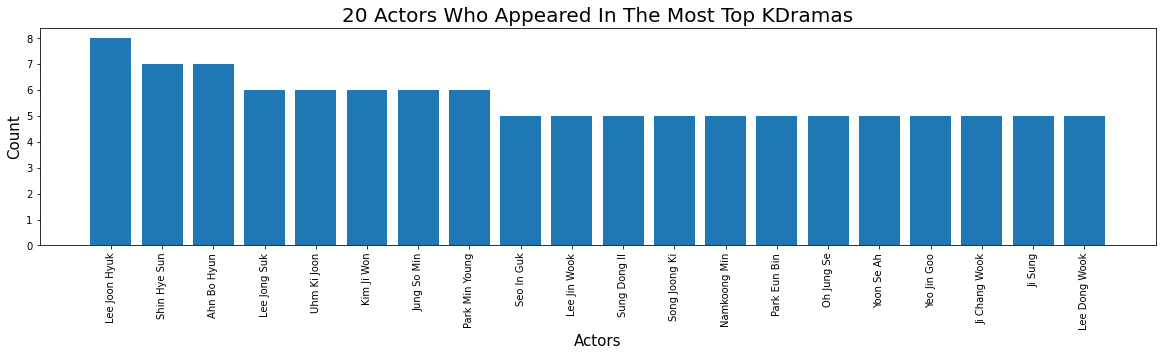

In [27]:
#bar graph
plt.figure(figsize=(20, 4))
plt.bar(data=cast_df.head(20), x = cast_df.iloc[:20].index, height='Appearance')

#plot title and axis labels
plt.title('20 Actors Who Appeared In The Most Top KDramas', fontsize=20)
plt.xlabel('Actors', fontsize=15)
plt.ylabel('Count', fontsize=15)

#rotate x-axis labels
plt.xticks(rotation=90)

plt.show()

## 3 Recommendation systems

In [28]:
#list of column names from to consider for creating combined features
features = ['Duration','Synopsis','Cast','Genre','Tags']

In [29]:
#ensures that 'Number of Episodes' is treated as a string when combining features later
ndf['Number of Episodes'] = ndf['Number of Episodes'].astype(str)

#concatenate values from the 'Synopsis', 'Genre', and 'Tags' columns, separated by a space, and assigns the concatenated values to the 'combined_features' column
ndf['combined_features'] = ndf['Synopsis'] + " " + ndf['Genre'] + " " + ndf['Tags']

In [30]:
#convert a collection of text documents into a matrix of token counts.
cv = CountVectorizer()

#transforms the text data into a matrix of token counts, where each row represents a document and each column represents a unique word
count_matrix = cv.fit_transform(ndf['combined_features'])

#cosine similarity measures the similarity between each pair of documents in the 'count_matrix'
cosine_sim = cosine_similarity(count_matrix)

### KDrama title searcher

In [31]:
#search for drama with the keyword
def kdrama_available(key):
    
    keyword = key
    
    print("Drama with keyword: [{}]".format(keyword))
    
    for i, mov in enumerate(ndf[ndf['Name'].str.contains(keyword)]['Name'].to_list()):
        print("{}) {} ".format(i+1,mov))

In [32]:
#searching for 'Extraordinary Attorney Woo'
kdrama_available('Extraordinary Attorney Woo')

Drama with keyword: [Extraordinary Attorney Woo]
1) Extraordinary Attorney Woo 


In [33]:
#tfdif is an importance score of each word in a document considering its frequency and rarity 
tfdif_vector = TfidfVectorizer(stop_words = 'english')

#tfidf_matrix contains the tfdif scores for each word in each synopsis.
tfidf_matrix = tfdif_vector.fit_transform(ndf['Synopsis'])

#represents the pairwise similarity scores
sim_matrix = linear_kernel(tfidf_matrix, tfidf_matrix)

#'Name' column is index. can map a drama name to its corresponding index in ndf. drop_duplicates ensures that each drama name has a unique index
indicies = pd.Series(ndf.index, index = ndf['Name']).drop_duplicates()

### Recommendation based of cosine similarity

In [34]:
#finds similar dramas based on the cosine similarity matrix, and prints the recommendations along with their similarity scores. If the user's input is not found in the database, it displays an error message.
def kdrama_recommendation(mov,sim_num = 5):

    user_choice = mov
    
    try:
        ref_index = ndf[ndf['Name'].str.contains(user_choice, case = False)].index[0]

        similar_movies = list(enumerate(cosine_sim[ref_index]))

        sorted_simmilar_movies = sorted(similar_movies, key = lambda x: x[1], reverse = True)[1:]

        print('\nRecomended K Drama for [{}]'.format(user_choice))
        print('-'*(24 + len(user_choice)))

        for i, element in enumerate(sorted_simmilar_movies):
            similar_movie_id = element[0]
            similar_movie_title = ndf['Name'].iloc[similar_movie_id]
            s_score = element[1]
            print('{:40} -> {:.3f}'.format(similar_movie_title, s_score))

            if i > sim_num:
                break
    except IndexError:
        print("\n[{}] is not in our database!".format(user_choice))
        print("We couldn't recommend anyting...Sorry...")

In [35]:
kdrama_recommendation('Extraordinary Attorney Woo')


Recomended K Drama for [Extraordinary Attorney Woo]
--------------------------------------------------
Law School                               -> 0.486
Run On                                   -> 0.485
Mother                                   -> 0.476
Touch Your Heart                         -> 0.473
Juvenile Justice                         -> 0.471
Welcome 2 Life                           -> 0.468
Lawless Lawyer                           -> 0.466


### Recommendation based of similarity matrix

In [36]:
#similar dramas based on the similarity matrix
def content_based_recommender(title, sim_scores = sim_matrix):
    idx = indicies[title]
    
    sim_scores = list(enumerate(sim_matrix[idx]))
    
    sim_scores = sorted(sim_scores, key = lambda x : x[1], reverse = True)
    
    sim_scores = sim_scores[1:11]
    
    drama_score = list()
    for score in sim_scores:
        drama_score.append(score[1])
    
    kdrama_indices = [i[0] for i in sim_scores]
    
    kdrama_name = ndf['Name'].iloc[kdrama_indices]
    
    print('\nRecomended KDrama for [{}]'.format(title))
    print('-'*(24 + len(title)))
    
    for score,name in list(zip(drama_score,kdrama_name)):
        print("{:30} -> {:.3f}".format(name,score))

In [37]:
#reducing words to their base or root form
lemmatizer = WordNetLemmatizer()

#remove stop words(a, the, is, etc.) because no significant meaning
stop_words = set(stopwords.words('english'))

#filter out non-verb words during text analysis tasks
VERB_CODES = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}

In [38]:
content_based_recommender('Extraordinary Attorney Woo')


Recomended KDrama for [Extraordinary Attorney Woo]
--------------------------------------------------
Law School                     -> 0.131
Reply 1997                     -> 0.123
Ghost                          -> 0.112
Defendant                      -> 0.106
My Roommate Is a Gumiho        -> 0.094
Moon Embracing the Sun         -> 0.091
Strangers from Hell            -> 0.090
Again My Life                  -> 0.086
I Hear Your Voice              -> 0.085
Navillera                      -> 0.083


In [39]:
#clean and normalize the text data from 'Synopsis' column of ndf
def preprocess_sentences(text):
    text = text.lower()
    temp_sent =[]
    words = nltk.word_tokenize(text)
    tags = nltk.pos_tag(words)
    for i, word in enumerate(words):
        if tags[i][1] in VERB_CODES: 
              lemmatized = lemmatizer.lemmatize(word, 'v')
        else:
              lemmatized = lemmatizer.lemmatize(word)
        if lemmatized not in stop_words and lemmatized.isalpha():
              temp_sent.append(lemmatized)

    finalsent = ' '.join(temp_sent)
    finalsent = finalsent.replace("n't", " not")
    finalsent = finalsent.replace("'m", " am")
    finalsent = finalsent.replace("'s", " is")
    finalsent = finalsent.replace("'re", " are")
    finalsent = finalsent.replace("'ll", " will")
    finalsent = finalsent.replace("'ve", " have")
    finalsent = finalsent.replace("'d", " would")
    return finalsent

ndf_copy = ndf.copy()
ndf_copy['synopsis_processed'] = ndf_copy['Synopsis'].apply(preprocess_sentences)
ndf_copy['synopsis_processed'].head()

0    geu roo young autistic man work father busines...
1    although baek hee sung hide dark secret surrou...
2    story people go day seemingly ordinary actuall...
3    everyday extraordinary five doctor patient ins...
4    park dong hoon engineer marry attorney kang yo...
Name: synopsis_processed, dtype: object

In [40]:
#find similar documents based on their cosine similarity values
tfdifvec = TfidfVectorizer()
tfdif_drama_processed = tfdifvec.fit_transform((ndf_copy['synopsis_processed']))
ndf_cosine = cosine_similarity(tfdif_drama_processed,tfdif_drama_processed)

### Recommendation based of similarity values

In [41]:
#picks indices of the top 10 KDramas with the highest cosine similarity values.
indices = pd.Series(ndf_copy['Name'])
  
def recommendations(title, cosine_sim = ndf_cosine):
    recommended_movies = []
    index = indices[indices == title].index[0]
    similarity_scores = pd.Series(cosine_sim[index]).sort_values(ascending = False)
    top_10_movies = list(similarity_scores.iloc[1:11].index)
    for i in top_10_movies:
        recommended_movies.append(list(ndf_copy['Name'].index)[i])
        
    print('\nRecomended KDrama for [{}]'.format(title))
    print('-'*(24 + len(title)))
    
    for index in recommended_movies:
        print(ndf_copy.iloc[index]['Name'])

In [42]:
recommendations('Extraordinary Attorney Woo')


Recomended KDrama for [Extraordinary Attorney Woo]
--------------------------------------------------
Law School
Voice 4: Judgment Hour
Defendant
I Hear Your Voice
Team Bulldog: Off-duty Investigation
Reply 1997
Blind
My Country: The New Age
Tree With Deep Roots
Strangers from Hell
